In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
from scipy.optimize import curve_fit
import pickle
# from cmblensplus/wrap/
import curvedsky as cs
# from cmblensplus/utils/
import cmb as CMB
import plottools as pl
import constant as c
import analysis as ana
import binning as bn
# others
import local
import tools_multitracer as mass
import tools_delens
import tools_cmb
import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib
importlib.reload(tools_delens)

<module 'tools_delens' from '/global/u1/t/toshiyan/Work/Ongoing/litebird/project-lens/tools_delens.py'>

In [3]:
def pdf_gauss(xs, amp, mean, sigma):
    return amp*np.exp(-(xs-mean)**2/(2*sigma**2))

In [235]:
simn = 500
num = 500
lbmin, lbmax = 2, 190
bN = 20
#area = 'lbonly'
area = 'lbfull'
#area = 'lbs4'
wmass = 3
method = 'cinv'
#method = 'bonly'

In [236]:
pobj = local.analysis()
cobj = tools_cmb.cmb_map()
dobj = tools_delens.filename(method=method)

In [237]:
mask = tools_cmb.prepare_masks()
Fsky = {m: np.average(mask[m]) for m in tools_cmb.masks}
fsky = Fsky[area]
print(fsky)
mb = bn.multipole_binning(bN,lmin=lbmin,lmax=lbmax,lstart=lbmin,spc='')
L = np.linspace(0,lbmax,lbmax+1)

0.48313407887083787


In [238]:
Ol = np.zeros((simn,lbmax+1-lbmin))
Rl = np.zeros((simn,lbmax+1-lbmin))
Ll = np.zeros((simn,lbmax+1-lbmin))
Xl = np.zeros((simn,lbmax+1-lbmin))
Ob = np.zeros((simn,bN))
Rb = np.zeros((simn,bN))
Lb = np.zeros((simn,bN))
Xb = np.zeros((simn,bN))
for rlz in range(1,simn+1):
    obb, rbb, lbb, xbb = np.loadtxt(dobj.cl[area][wmass][rlz],usecols=(0,1,2,3),unpack=True)[:,lbmin:lbmax+1]
    Ol[rlz-1,:] = obb/fsky
    Rl[rlz-1,:] = rbb/fsky
    Ll[rlz-1,:] = lbb/fsky
    Xl[rlz-1,:] = xbb/fsky
    Ob[rlz-1,:] = bn.binning(obb,mb)/fsky
    Rb[rlz-1,:] = bn.binning(rbb,mb)/fsky
    Lb[rlz-1,:] = bn.binning(lbb,mb)/fsky
    Xb[rlz-1,:] = bn.binning(xbb,mb)/fsky

In [239]:
mOl = np.mean(Ol,axis=0)
mRl = np.mean(Rl,axis=0)
mLl = np.mean(Ll,axis=0)
mXl = np.mean(Xl,axis=0)
mOb = np.mean(Ob,axis=0)
mRb = np.mean(Rb,axis=0)
mLb = np.mean(Lb,axis=0)
mXb = np.mean(Xb,axis=0)
mAl = mXl/mLl
mAb = mXb/mLb

In [240]:
Dl = Ol - 2*mAl*Xl + mAl**2*Ll
Db = Ob - 2*mAb*Xb + mAb**2*Lb
mDl = np.mean(Dl,axis=0)

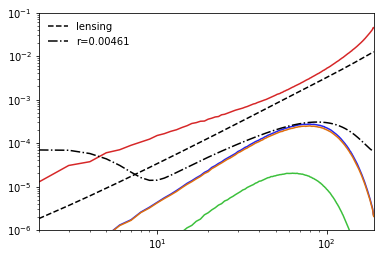

In [241]:
xlim(2,lbmax)
ylim(1e-6,1e-1)
Lfac = c.Tcmb**2*L[lbmin:]*(L[lbmin:]+1)/(2*np.pi)
loglog(L[lbmin:],Lfac*mOl)
#loglog(L[lbmin:],Lfac*mXl)
#loglog(L[lbmin:],Lfac*mLl)
loglog(L[lbmin:],Lfac*mDl)
loglog(L[lbmin:],Lfac*mRl*0.00461)
loglog(L[lbmin:],Lfac*pobj.clfg[lbmin:lbmax+1])
loglog(L[lbmin:],Lfac*pobj.lcl[2][lbmin:lbmax+1],label='lensing',color='k',ls='--')
loglog(L[lbmin:],Lfac*pobj.tcl[2][lbmin:lbmax+1]*0.00461,label='r=0.00461',color='k',ls='-.')
legend()

In [242]:
rs = np.arange(-7e-3+40*5e-5,7e-3,5e-5)
#rs = np.arange(0.,7e-3,5e-5)
x = 1e3*rs

In [243]:
lnLo = np.zeros((num,len(rs)))
lnLd = np.zeros((num,len(rs)))
for rlz in range(num):
    obb0, lbb0, xbb0 = np.loadtxt(dobj.cl[area][wmass][simn+rlz+1],usecols=(0,2,3),unpack=True)[:,lbmin:lbmax+1]
    oOb = bn.binning(obb0/fsky,mb)
    oDb = oOb - 2*mAb*bn.binning(xbb0/fsky,mb) + mAb**2*bn.binning(lbb0/fsky,mb)
    lnLo[rlz,:] = tools_delens.compute_HL_r(oOb,Ob,mRb,rs)
    lnLd[rlz,:] = tools_delens.compute_HL_r(oDb,Db,mRb,rs)
    #if np.isnan(np.sum(lnLo[rlz,:])): print(rlz,lnLo[rlz,:])
    #if np.isnan(np.sum(lnLd[rlz,:])): print(rlz,lnLd[rlz,:])

In [244]:
osigma = np.zeros((num,3))
dsigma = np.zeros((num,3))
for rlz in range(num):
    #osigma[rlz,0] = rs[ np.argmax( np.exp(lnLo[rlz]-np.max(lnLo[rlz])) ) ]
    #dsigma[rlz,0] = rs[ np.argmax( np.exp(lnLd[rlz]-np.max(lnLd[rlz])) ) ]
    osigma[rlz,:], __ = curve_fit(pdf_gauss, x, np.exp(lnLo[rlz]-np.max(lnLo[rlz])) )
    dsigma[rlz,:], __ = curve_fit(pdf_gauss, x, np.exp(lnLd[rlz]-np.max(lnLd[rlz])) )

In [245]:
print(np.mean(osigma,axis=0))
print(np.mean(dsigma,axis=0))
print(np.std(osigma[:,1]))
print(np.std(dsigma[:,1]))

[0.96612208 0.16591006 1.16158263]
[0.95414106 0.21127234 1.05566915]
1.3564565358406302
1.3591899048759073


In [246]:
resto = np.zeros(num)
restd = np.zeros(num)
for rlz in range(num):
    obb0, lbb0, xbb0 = np.loadtxt(dobj.cl[area][wmass][simn+rlz+1],usecols=(0,2,3),unpack=True)[:,lbmin:lbmax+1]
    oOb = bn.binning(obb0/fsky,mb)
    oDb = oOb - 2*mAb*bn.binning(xbb0/fsky,mb) + mAb**2*bn.binning(lbb0/fsky,mb)
    resto[rlz] = tools_delens.simple_r(oOb,Ob,mRb)
    restd[rlz] = tools_delens.simple_r(oDb,Db,mRb)

In [247]:
print(np.std(resto))
print(np.std(restd))

0.0013281859155401424
0.0012438686054539086


In [179]:
if area == 'lbonly':
    Resto = {}
    Restd = {}
    Resto['lbonly'] = resto
    Restd['lbonly'] = restd

In [180]:
if area == 'lbs4':
    Resto['lbs4'] = resto
    Restd['lbs4'] = restd

In [181]:
Rest_o = (Resto['lbs4']/np.std(Resto['lbs4'])**2 + Resto['lbonly']/np.std(Resto['lbonly'])**2)/(1./np.std(Resto['lbs4'])**2 + 1./np.std(Resto['lbonly'])**2)
Rest_d = (Restd['lbs4']/np.std(Restd['lbs4'])**2 + Restd['lbonly']/np.std(Restd['lbonly'])**2)/(1./np.std(Restd['lbs4'])**2 + 1./np.std(Restd['lbonly'])**2)

In [182]:
print(np.std(Rest_o))
print(np.std(Rest_d))

0.001384702271975309
0.0011778083677842584


1.3376561456213525
1.284759449154916


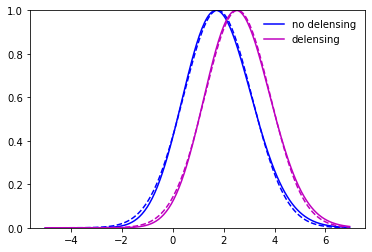

In [66]:
#xlim(-7,7)
rlz = 7
ylim(0,1)
Po = np.exp(lnLo[rlz]-np.max(lnLo[rlz]))
Pd = np.exp(lnLd[rlz]-np.max(lnLd[rlz]))
popto, __ = curve_fit(pdf_gauss, x, Po)
print(popto[2])
poptd, __ = curve_fit(pdf_gauss, x, Pd)
print(poptd[2])
plot(x,Po,label='no delensing',color='b')
plot(x,pdf_gauss(x, popto[0], popto[1], popto[2]),color='b',ls='--')
plot(x,Pd,label='delensing',color='m')
plot(x,pdf_gauss(x, poptd[0], poptd[1], poptd[2]),color='m',ls='--')
legend()